In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 15.7 MB/s 
     |████████████████████████████████| 441 kB 77.0 MB/s 
     |████████████████████████████████| 7.6 MB 76.3 MB/s 
     |████████████████████████████████| 163 kB 92.7 MB/s 
     |████████████████████████████████| 212 kB 64.4 MB/s 
     |████████████████████████████████| 115 kB 78.4 MB/s 
     |████████████████████████████████| 127 kB 74.6 MB/s 
     |████████████████████████████████| 115 kB 98.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# only run this cell if you are in collab
!pip install transformers -Uqq
!pip install datasets -Uqq
!pip install bert-score -Uqq
!pip install sacremoses
!pip install ohmeow-blurr -Uqq

     |████████████████████████████████| 60 kB 6.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 14.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d71144a6a2f259b850bbbfd833b5798d667c521218813fd6bdb85b2f7053967b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
     |████████████████████████████████| 81 kB 7.4 MB/s 
     |████████████████████████████████| 1.3 MB 79.0 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 


In [3]:
!wget -nc https://raw.githubusercontent.com/pam1202g/nlp_demos/main/text_summarization_ds.csv

--2022-10-30 07:19:07--  https://raw.githubusercontent.com/pam1202g/nlp_demos/main/text_summarization_ds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65649 (64K) [text/plain]
Saving to: ‘text_summarization_ds.csv’

text_summarization_ 100%[===================>]  64.11K  --.-KB/s    in 0.003s  

2022-10-30 07:19:07 (18.1 MB/s) - ‘text_summarization_ds.csv’ saved [65649/65649]



In [4]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import datasets
from fastai.text.all import *
from transformers import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

import nltk
nltk.download('punkt', quiet=True)


/usr/local/lib/python3.7/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


True

In [5]:
df = pd.read_csv('text_summarization_ds.csv')

In [6]:
df.head()

,Title,Text,Summary
0,State of the Art in Dense Monocular Non-Rigid 3D Reconstruction,"3D reconstruction of deformable (or non-rigid) scenes from a set of monocular 2D image observations is a long-standing and actively researched area of computer vision and graphics. It is an ill-posed inverse problem, since--without additional prior assumptions--it permits infinitely many solutions leading to accurate projection to the input 2D images. Non-rigid reconstruction is a foundational building block for downstream applications like robotics, AR/VR, or visual content creation. The key advantage of using monocular cameras is their omnipresence and availability to the end users as we...",3D reconstruction of deformable (or non-rigid) scenes from a set of monocular 2D image observations is a long-standing and actively researched area of computer vision and graphics.
1,Deep Generative Models on 3D Representations: A Survey,"Generative models, as an important family of statistical modeling, target learning the observed data distribution via generating new instances. Along with the rise of neural networks, deep generative models, such as variational autoencoders (VAEs) and generative adversarial network (GANs), have made tremendous progress in 2D image synthesis. Recently, researchers switch their attentions from the 2D space to the 3D space considering that 3D data better aligns with our physical world and hence enjoys great potential in practice. However, unlike a 2D image, which owns an efficient representat...","Generative models, as an important family of statistical modeling, target learning the observed data distribution via generating new instances.we make a thorough review of the development of 3D generation, including 3D shape generation and 3D-aware image synthesis, from the perspectives of both algorithms and more importantly representations"
2,Revisiting the ACVI Method for Constrained Variational Inequalities,"ACVI is a recently proposed first-order method for solving variational inequalities (VIs) with general constraints. Yang et al. (2022) showed that the gap function of the last iterate decreases at a rate of (1K√) when the operator is L-Lipschitz, monotone, and at least one constraint is active. In this work, we show that the same guarantee holds when only assuming that the operator is monotone. To our knowledge, this is the first analytically derived last-iterate convergence rate for general monotone VIs, and overall the only one that does not rely on the assumption that the operator is L-...","ACVI is a recently proposed first-order method for solving variational inequalities (VIs) with general constraints.Yang et al. (2022) showed that the gap function of the last iterate decreases at a rate of (1K√) when the operator is L-Lipschitz, monotone, and at least one constraint is active"
3,All the Feels: A dexterous hand with large area sensing,"High cost and lack of reliability has precluded the widespread adoption of dexterous hands in robotics. Furthermore, the lack of a viable tactile sensor capable of sensing over the entire area of the hand impedes the rich, low-level feedback that would improve learning of dexterous manipulation skills. This paper introduces an inexpensive, modular, robust, and scalable platform - the DManus- aimed at resolving these challenges while satisfying the large-scale data collection capabilities demanded by deep robot learning paradigms. Studies on human manipulation point to the criticality of lo...","High cost and lack of reliability has precluded the widespread adoption of dexterous hands in robotics.This paper introduces an inexpensive, modular, robust, and scalable platform - the DManus- aimed at resolving these challenges while satisfying the large-scale data collection capabilities demanded by deep robot learning paradigms"
4,Learning to predict arbitrary quantum processes,"We present an efficient machine learning (ML) algorithm for predicting any unknown quantum process over n qubit

In [7]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='text_summarization_ds.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e6c8bf40c8e50ed3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Text', 'Summary'],
        num_rows: 40
    })
})

In [9]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)

In [10]:
split

DatasetDict({
    train: Dataset({
        features: ['Title', 'Text', 'Summary'],
        num_rows: 32
    })
    test: Dataset({
        features: ['Title', 'Text', 'Summary'],
        num_rows: 8
    })
})

In [11]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [12]:
hf_model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [13]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'max_length': 142,
 'min_length': 56,
 'do_sample': False,
 'early_stopping': True,
 'num_beams': 4,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'bad_words_ids': None,
 'bos_token_id': 0,
 'pad_token_id': 1,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'no_repeat_ngram_size': 3,
 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1,
 'decoder_start_token_id': 2,
 'use_cache': True,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None,
 'suppress_tokens': None,
 'begin_suppress_tokens': None}

In [14]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('Text'), get_y=ColReader('Summary'), splitter=RandomSplitter())

In [15]:
dls = dblock.dataloaders(df, bs=2)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [16]:
len(dls.train.items), len(dls.valid.items)

(32, 8)

In [17]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 115]))

In [18]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> The ability to identify influential training examples enables us to debug training data and explain model behavior. Existing techniques to do so are based on the flow of training data influence through the model parameters. For large models in NLP applications, it is often computationally infeasible to study this flow through all model parameters, therefore techniques usually pick the last layer of weights. However, we observe that since the activation connected to the last layer of weights contains ""shared logic"", the data influenced calculated via the last layer weights prone to a ``cancellation effect'', where the data influence of different examples have large magnitude that contradicts each other. The cancellation effect lowers the discriminative power of the influence score, and deleting influential examples according to this measure often does not change the model's behavior by much. To mitigate this, we propose a technique called TracIn-WE that modifies a method called TracIn to operate on the word embedding layer instead of the last layer, where the cancellation effect is less severe. One potential concern is that influence based on the word embedding layer may not encode sufficient high level information. However, we find that gradients (unlike embeddings) do not suffer from this, possibly because they chain through higher layers</s>","The ability to identify influential training examples enables us to debug training data and explain model behavior. For large models in NLP applications, it is often computationally infeasible to study this flow through all model parameters, therefore techniques usually pick the last layer of weights.we propose a technique called TracIn-WE that modifies a method called TracIn to operate on the word embedding layer instead of the last layer, where the cancellation effect is less severe."
1,"<s> Finding unified complexity measures and algorithms for sample-efficient learning is a central topic of research in reinforcement learning (RL). The Decision-Estimation Coefficient (DEC) is recently proposed by Foster et al. (2021) as a necessary and sufficient complexity measure for sample-efficient no-regret RL. This paper makes progress towards a unified theory for RL with the DEC framework. First, we propose two new DEC-type complexity measures: Explorative DEC (EDEC), and Reward-Free DEC (RFDEC). We show that they are necessary and sufficient for sample-efficient PAC learning and reward-free learning, thereby extending the original DEC which only captures no-regret learning. Next, we design new unified sample-efficient algorithms for all three learning goals. Our algorithms instantiate variants of the Estimation-To-Decisions (E2D) meta-algorithm with a strong and general model estimation subroutine. Even in the no-regret setting, our algorithm E2D-TA improves upon the algorithms of Foster et al. (2021) which require either bounding a variant of the DEC which may be prohibitively large, or designing problem-specific estimation subroutines. As applications, we recover existing</s>","Finding unified complexity measures and algorithms for sample-efficient learning is a central topic of research in reinforcement learning (RL).This paper makes progress towards a unified theory for RL with the DEC framework. First, we propose two new DEC-type complexity measures: Explorative DEC (EDEC), and Reward-Free DEC (RFDEC).Next, we design new unified sample-efficient algorithms for all three learning goals. Finally, as a connection, we re-analyze two existing optimistic model-based algorithms based on Posterior Sampling or Maximum Likelihood Estimation"


In [19]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [20]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "
/usr/local/lib/python3.7

SuggestedLRs(valley=9.120108734350652e-05)

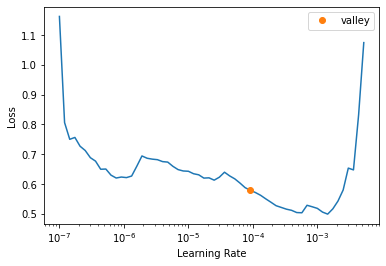

In [21]:
learn.lr_find()

In [22]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


(3,
 tensor(1.1851, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([2, 115, 50264]))

In [23]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,0.637166,0.542758,0.569748,0.450985,0.513262,0.917105,0.909532,0.913252,00:46


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

In [24]:
learn.show_results(learner=learn, max_n=2)


,text,target,prediction
0,"Electronic music artists and sound designers have unique workflow practices that necessitate specialized approaches for developing music information retrieval and creativity support tools. Furthermore, electronic music instruments, such as modular synthesizers, have near-infinite possibilities for sound creation and can be combined to create unique and complex audio paths. The process of discovering interesting sounds is often serendipitous and impossible to replicate. For this reason, many musicians in electronic genres record audio output at all times while they work in the studio. Subsequently, it is difficult for artists to rediscover audio segments that might be suitable for use in their compositions from thousands of hours of recordings. In this paper, we describe LyricJam Sonic -- a novel creative tool for musicians to rediscover their previous recordings, re-contextualize them with other recordings, and create original live music compositions in real-time. A bi-modal AI-driven approach uses generated lyric lines to find matching audio clips from the artist's past studio recordings, and uses them to generate new lyric lines, which in turn are used to find other clips, thus creating a continuous and evolving stream of music and lyrics. The intent is to keep the artists in a state of creative flow conducive to music creation rather than taking them into an analytical/critical","Electronic music artists and sound designers have unique workflow practices that necessitate specialized approaches for developing music information retrieval and creativity support tools. In this paper, we describe LyricJam Sonic -- a novel creative tool for musicians to rediscover their previous recordings, re-contextualize them with other recordings, and create original live music compositions in real-time.","[LyricJam Sonic is a novel creative tool for musicians to rediscover their previous recordings, re-contextualize them with other recordings, and create original live music compositions in real-time. A bi-modal AI-driven approach uses generated lyric lines to find matching audio clips from the artist's past studio recordings., Schema-aware Reference As Prompt (RAP) can leverage knowledge inherited from global (few-shot) training data for each sample. Experimental results demonstrate that RAP can be plugged into various existing models and outperforms baselines in low-resource settings on four datasets of relational triple extraction and event extraction.]"


In [25]:
test_article='''
The Visual-and-Language Navigation (VLN) task requires understanding a textual instruction to navigate a natural indoor environment using only visual information. While this is a trivial task for most humans, it is still an open problem for AI models. In this work, we hypothesize that poor use of the visual information available is at the core of the low performance of current models. To support this hypothesis, we provide experimental evidence showing that state-of-the-art models are not severely affected when they receive just limited or even no visual data, indicating a strong overfitting to the textual instructions. To encourage a more suitable use of the visual information, we propose a new data augmentation method that fosters the inclusion of more explicit visual information in the generation of textual navigational instructions. Our main intuition is that current VLN datasets include textual instructions that are intended to inform an expert navigator, such as a human, but not a beginner visual navigational agent, such as a randomly initialized DL model. Specifically, to bridge the visual semantic gap of current VLN datasets, we take advantage of metadata available for the Matterport3D dataset that, among others, includes information about object labels that are present in the scenes. Training a state-of-the-art model with the new set of instructions increase its performance by 8% in terms of success rate on unseen environments, demonstrating the advantages of the proposed data augmentation method.
'''

In [28]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=1)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
{'summary_texts': 'The Visual-and-Language Navigation task requires understanding a textual instruction to navigate a natural indoor environment using only visual information. We propose a new data augmentation method that fosters the inclusion of more explicit visual information in the generation of textual navigational instructions. Training a state-of-the-art model with the new set of instructions increase its performance by 8% in terms of success rate on unseen environments.'}



In [30]:
learn.metrics = None
learn.export(fname='arxiv_summary_export.pkl')

In [31]:
inf_learn = load_learner(fname='arxiv_summary_export.pkl')
inf_learn.blurr_summarize(test_article)

[{'summary_texts': 'The Visual-and-Language Navigation task requires understanding a textual instruction to navigate a natural indoor environment using only visual information. We propose a new data augmentation method that fosters the inclusion of more explicit visual information in the generation of textual navigational instructions. Training a state-of-the-art model with the new set of instructions increase its performance by 8% in terms of success rate on unseen environments.'}]